# Community & Cultural Assets at Risk from Wildfire
## Privacy-Preserving Analysis for Tribal Lands

Lilly Jones, PhD

**Data Sovereignty & Tribal Consent**

This notebook analyzes exposure of community and cultural assets to wildfire risk. However:

- **Cultural site locations are NEVER shared without explicit Tribal consent**
- **Data sovereignty principles are paramount**
- **Privacy-preserving methods are used throughout**
- **Aggregation and buffering protect sensitive locations**
- **Output maps use generalized representations only**

**Before Using This Notebook:**
1. Obtain explicit Tribal council approval for data use
2. Establish data sharing agreements
3. Review outputs with Tribal cultural officers
4. Never share precise coordinates of cultural sites
5. Respect Tribal data governance protocols

**Outputs:**
- Community infrastructure exposure assessment
- Privacy-preserving cultural asset risk zones
- Evacuation route vulnerability analysis
- Fire scenario impact modeling
- Aggregated risk summaries (no precise locations)

## Imports and dependencies

In [ ]:
# Install required packages (uncomment if needed) or use the tribal_fire.yaml located in this repository.
# !pip install geopandas pandas numpy matplotlib seaborn rasterio rioxarray shapely networkx contextily folium

In [ ]:
# Imports
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
from shapely.geometry import Point, LineString, Polygon, box, MultiPolygon
from shapely.ops import unary_union, nearest_points
import rasterio
from rasterio.features import rasterize
import networkx as nx
import warnings
from datetime import datetime
from pathlib import Path
import json
import folium
from folium import plugins

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded successfully")
print("\nREMINDER: Obtain Tribal consent before using sensitive data")

Libraries loaded successfully

REMINDER: Obtain tribal consent before using sensitive data


## Privacy and Data Governance Framework

### Define Privacy Protection Levels

In [2]:
# Privacy protection framework
PRIVACY_LEVELS = {
    'public': {
        'description': 'Public infrastructure (schools, clinics)',
        'buffer_distance_m': 0,
        'show_exact_location': True,
        'aggregation_required': False
    },
    'sensitive': {
        'description': 'Residences, gathering places',
        'buffer_distance_m': 500,  # 500m buffer
        'show_exact_location': False,
        'aggregation_required': True
    },
    'highly_sensitive': {
        'description': 'Cultural/sacred sites',
        'buffer_distance_m': 1000,  # 1km buffer minimum
        'show_exact_location': False,
        'aggregation_required': True,
        'tribal_consent_required': True
    }
}

# Analysis parameters include meters from high-risk areas, meters on either side of route, minimum features before showing aggregated data, 
# obfuscating precise location to protect sensitive locations, and Tribal review of outputs before use or publication is required. 
ANALYSIS_CONFIG = {
    'fire_risk_zones': [100, 300, 500, 1000, 2000],  
    'evacuation_buffer': 100,  
    'minimum_aggregation': 3,  
    'cultural_site_general_zones_only': True,  
    'require_tribal_review': True  
}

print("PRIVACY & DATA GOVERNANCE FRAMEWORK")
print("="*80)
print("\nProtection Levels:")
for level, config in PRIVACY_LEVELS.items():
    print(f"\n{level.upper()}:")
    print(f"  Description: {config['description']}")
    print(f"  Buffer: {config['buffer_distance_m']}m")
    print(f"  Exact Location: {config['show_exact_location']}")
    if config.get('tribal_consent_required'):
        print(f"TRIBAL CONSENT REQUIRED")

print("\n" + "="*80)
print("All outputs will be reviewed for privacy compliance before export.")
print("="*80)

PRIVACY & DATA GOVERNANCE FRAMEWORK

Protection Levels:

PUBLIC:
  Description: Public infrastructure (schools, clinics)
  Buffer: 0m
  Exact Location: True

SENSITIVE:
  Description: Residences, gathering places
  Buffer: 500m
  Exact Location: False

HIGHLY_SENSITIVE:
  Description: Cultural/sacred sites
  Buffer: 1000m
  Exact Location: False
TRIBAL CONSENT REQUIRED

All outputs will be reviewed for privacy compliance before export.


## Load Data

### Load Tribal Boundaries

In [3]:
# Load tribal boundaries
# Real source: BIA AIAN Lands https://biamaps.doi.gov/

# Example: Create sample tribal boundary
sample_reservation = {
    'reservation_name': 'White Mountain Apache',
    'tribe': 'White Mountain Apache Tribe',
    'state': 'AZ',
    'acres': 1664872,
    'population': 15000
}

# Create boundary geometry (simplified)
center_lon, center_lat = -110.0, 33.8
reservation_boundary = gpd.GeoDataFrame(
    [sample_reservation],
    geometry=[Point(center_lon, center_lat).buffer(0.4)],
    crs='EPSG:4326'
)

# Reproject to metric CRS for distance calculations
reservation_boundary_metric = reservation_boundary.to_crs('EPSG:5070')

print(f"Loaded reservation: {sample_reservation['reservation_name']}")
print(f"Area: {sample_reservation['acres']:,} acres")
print(f"Population: {sample_reservation['population']:,}")

Loaded reservation: White Mountain Apache
Area: 1,664,872 acres
Population: 15,000


### Load/Generate Community Infrastructure

**Real Data Sources:**
- **HIFLD** (Homeland Infrastructure Foundation-Level Data): Schools, hospitals
- **Tribal GIS Departments**: Authoritative source (with consent)
- **OpenStreetMap**: Some public facilities
- **Census TIGER**: Building footprints

In [4]:
def generate_community_infrastructure(reservation_boundary, n_features=30):
    """
    Generate sample community infrastructure.
    In practice, load from Tribal GIS department with proper consent.
    """
    bounds = reservation_boundary.total_bounds
    
    # Generate random points within boundary
    features = []
    
    # Infrastructure types
    infrastructure_types = [
        {'type': 'School', 'privacy': 'public', 'count': 5},
        {'type': 'Health Clinic', 'privacy': 'public', 'count': 3},
        {'type': 'Community Center', 'privacy': 'public', 'count': 2},
        {'type': 'Elder Housing', 'privacy': 'sensitive', 'count': 4},
        {'type': 'Fire Station', 'privacy': 'public', 'count': 2},
        {'type': 'Water Tank', 'privacy': 'public', 'count': 3},
        {'type': 'Tribal Office', 'privacy': 'public', 'count': 2},
        {'type': 'Housing Area', 'privacy': 'sensitive', 'count': 10}
    ]
    
    feature_id = 0
    for infra in infrastructure_types:
        for i in range(infra['count']):
            # Random point within bounds
            lon = np.random.uniform(bounds[0], bounds[2])
            lat = np.random.uniform(bounds[1], bounds[3])
            point = Point(lon, lat)
            
            # Check if within reservation
            if reservation_boundary.contains(point).any():
                features.append({
                    'feature_id': f"{infra['type'][:3].upper()}_{feature_id:03d}",
                    'name': f"{infra['type']} {i+1}",
                    'type': infra['type'],
                    'privacy_level': infra['privacy'],
                    'population': np.random.randint(10, 200) if 'Housing' in infra['type'] else np.random.randint(5, 50),
                    'geometry': point
                })
                feature_id += 1
    
    return gpd.GeoDataFrame(features, crs='EPSG:4326')

# Generate infrastructure
community_assets = generate_community_infrastructure(reservation_boundary)

print("\nCOMMUNITY INFRASTRUCTURE LOADED")
print("="*80)
print(f"Total features: {len(community_assets)}")
print("\nBy type:")
print(community_assets['type'].value_counts())
print("\nBy privacy level:")
print(community_assets['privacy_level'].value_counts())

display(community_assets.head())


COMMUNITY INFRASTRUCTURE LOADED
Total features: 27

By type:
type
Housing Area        10
School               3
Health Clinic        3
Elder Housing        3
Water Tank           3
Community Center     2
Fire Station         2
Tribal Office        1
Name: count, dtype: int64

By privacy level:
privacy_level
public       14
sensitive    13
Name: count, dtype: int64


,feature_id,name,type,privacy_level,population,geometry
0,SCH_000,School 1,School,public,20,POINT (-110.31543 33.62086)
1,SCH_001,School 3,School,public,48,POINT (-110.20866 33.48265)
2,SCH_002,School 5,School,public,44,POINT (-110.26709 33.51373)
3,HEA_003,Health Clinic 1,Health Clinic,public,48,POINT (-110.14996 33.43236)
4,HEA_004,Health Clinic 2,Health Clinic,public,28,POINT (-109.89993 33.53802)


### Load/Generate Cultural Sites (Requires Tribal Consent)

**Cultural Site Data**

- **NEVER use without explicit Tribal consent**
- Stored separately with restricted access
- Only Tribal departments have access
- Analysis results shown in generalized zones only
- No coordinates exported

In [5]:
def generate_cultural_sites_example(reservation_boundary, consent_obtained=False):
    """
    Example framework for cultural sites.
    
    IN PRACTICE:
    - Only load if Tribal consent obtained
    - Use Tribal GIS department data
    - Store in encrypted, access-controlled database
    - Never export coordinates
    """
    if not consent_obtained:
        print("CONSENT NOT OBTAINED")
        print("Cultural site analysis disabled.")
        print("Contact tribal cultural preservation office for data access.")
        return gpd.GeoDataFrame()
    
    bounds = reservation_boundary.total_bounds
    
    # Example types (actual categories defined by tribe)
    site_types = [
        'Sacred Site',
        'Ceremonial Ground',
        'Traditional Use Area',
        'Historic Site',
        'Burial Ground'
    ]
    
    sites = []
    for i, site_type in enumerate(site_types):
        for j in range(2):
            lon = np.random.uniform(bounds[0], bounds[2])
            lat = np.random.uniform(bounds[1], bounds[3])
            
            sites.append({
                'site_id': f"CULTURAL_{i*2+j:03d}",  # Anonymized ID only
                'type_general': 'Cultural Site',  # Generalized category
                'type_specific': site_type,  # For internal use only
                'privacy_level': 'highly_sensitive',
                'consent_date': '2024-01-15',  # Track consent
                'geometry': Point(lon, lat)
            })
    
    gdf = gpd.GeoDataFrame(sites, crs='EPSG:4326')
    
    print("SENSITIVE DATA LOADED")
    print("Tribal consent obtained: 2024-01-15")
    print("All outputs will use privacy-preserving aggregation.")
    
    return gdf

# This example uses synthetic data; in practice, check with the Tribe and obtain consent first
CONSENT_OBTAINED = True  # SET TO FALSE without actual consent

cultural_sites = generate_cultural_sites_example(
    reservation_boundary,
    consent_obtained=CONSENT_OBTAINED
)

if len(cultural_sites) > 0:
    print(f"\nCultural sites loaded: {len(cultural_sites)}")
    print("Privacy level: HIGHLY SENSITIVE")
    print("Output format: Generalized zones only")

SENSITIVE DATA LOADED
Tribal consent obtained: 2024-01-15
All outputs will use privacy-preserving aggregation.

Cultural sites loaded: 10
Privacy level: HIGHLY SENSITIVE
Output format: Generalized zones only


### Load/Generate Evacuation Routes

In [6]:
def generate_evacuation_routes(reservation_boundary, n_routes=5):
    """
    Generate sample evacuation routes.
    In practice, load from:
    - Tribal emergency management
    - OpenStreetMap roads
    - State DOT data
    """
    bounds = reservation_boundary.total_bounds
    
    routes = []
    
    # Main highways (primary evacuation)
    for i in range(2):
        # Create line from south to north
        x_offset = (i - 0.5) * 0.3
        coords = [
            (bounds[0] + 0.2 + x_offset, bounds[1] + 0.1),
            (bounds[0] + 0.2 + x_offset, bounds[3] - 0.1)
        ]
        
        routes.append({
            'route_id': f"HWY_{i+1}",
            'name': f"Highway {i+1}",
            'type': 'Primary',
            'lanes': 2,
            'capacity_vehicles_per_hour': 1200,
            'geometry': LineString(coords)
        })
    
    # Secondary roads
    for i in range(3):
        # Create winding roads
        n_points = 5
        x_coords = np.linspace(bounds[0] + 0.1, bounds[2] - 0.1, n_points)
        y_coords = np.random.uniform(bounds[1] + 0.1, bounds[3] - 0.1, n_points)
        coords = list(zip(x_coords, y_coords))
        
        routes.append({
            'route_id': f"RD_{i+1}",
            'name': f"Road {i+1}",
            'type': 'Secondary',
            'lanes': 1,
            'capacity_vehicles_per_hour': 400,
            'geometry': LineString(coords)
        })
    
    return gpd.GeoDataFrame(routes, crs='EPSG:4326')

# Generate evacuation routes
evacuation_routes = generate_evacuation_routes(reservation_boundary)

print("\nEVACUATION ROUTES LOADED")
print("="*80)
print(f"Total routes: {len(evacuation_routes)}")
print("\nBy type:")
print(evacuation_routes['type'].value_counts())
print(f"\nTotal capacity: {evacuation_routes['capacity_vehicles_per_hour'].sum():,} vehicles/hour")

display(evacuation_routes)


EVACUATION ROUTES LOADED
Total routes: 5

By type:
type
Secondary    3
Primary      2
Name: count, dtype: int64

Total capacity: 3,600 vehicles/hour


,route_id,name,type,lanes,capacity_vehicles_per_hour,geometry
0,HWY_1,Highway 1,Primary,2,1200,"LINESTRING (-110.35000 33.50000, -110.35000 34..."
1,HWY_2,Highway 2,Primary,2,1200,"LINESTRING (-110.05000 33.50000, -110.05000 34..."
2,RD_1,Road 1,Secondary,1,400,"LINESTRING (-110.30000 33.82118, -110.15000 33..."
3,RD_2,Road 2,Secondary,1,400,"LINESTRING (-110.30000 33.87120, -110.15000 33..."
4,RD_3,Road 3,Secondary,1,400,"LINESTRING (-110.30000 33.77739, -110.15000 33..."


### Load/Generate Fire Risk Data

In [7]:
def generate_fire_risk_zones(reservation_boundary):
    """
    Generate fire risk zones.
    
    Real data sources:
    - LANDFIRE Wildfire Hazard Potential
    - State hazard assessments
    - Tribal fire risk models
    """
    bounds = reservation_boundary.total_bounds
    
    # Create grid
    grid_size = 0.05  # degrees
    x_coords = np.arange(bounds[0], bounds[2], grid_size)
    y_coords = np.arange(bounds[1], bounds[3], grid_size)
    
    risk_zones = []
    
    for x in x_coords:
        for y in y_coords:
            # Create cell
            cell = box(x, y, x + grid_size, y + grid_size)
            
            # Check if intersects reservation
            if reservation_boundary.geometry.iloc[0].intersects(cell):
                # Assign risk level (simplified)
                # Higher risk near edges (interface areas)
                centroid = cell.centroid
                dist_to_center = Point(bounds[0] + (bounds[2]-bounds[0])/2,
                                      bounds[1] + (bounds[3]-bounds[1])/2).distance(centroid)
                
                if dist_to_center > 0.3:
                    risk = 'High'
                    risk_score = np.random.uniform(7, 10)
                elif dist_to_center > 0.15:
                    risk = 'Moderate'
                    risk_score = np.random.uniform(4, 7)
                else:
                    risk = 'Low'
                    risk_score = np.random.uniform(1, 4)
                
                risk_zones.append({
                    'risk_level': risk,
                    'risk_score': risk_score,
                    'geometry': cell
                })
    
    return gpd.GeoDataFrame(risk_zones, crs='EPSG:4326')

# Generate fire risk zones
fire_risk = generate_fire_risk_zones(reservation_boundary)

print("\nFIRE RISK ZONES GENERATED")
print("="*80)
print(f"Total cells: {len(fire_risk)}")
print("\nRisk distribution:")
print(fire_risk['risk_level'].value_counts())
print(f"\nMean risk score: {fire_risk['risk_score'].mean():.2f}")


FIRE RISK ZONES GENERATED
Total cells: 226

Risk distribution:
risk_level
High        114
Moderate     80
Low          32
Name: count, dtype: int64

Mean risk score: 6.53


## Spatial Analyses

### Create Privacy Buffers

In [8]:
def apply_privacy_buffers(features_gdf, privacy_levels_config):
    """
    Apply privacy buffers to features based on sensitivity level.
    """
    buffered_features = features_gdf.copy()
    
    # Convert to metric CRS for accurate buffering
    buffered_features = buffered_features.to_crs('EPSG:5070')
    
    # Apply buffers
    for idx, row in buffered_features.iterrows():
        privacy_level = row['privacy_level']
        buffer_dist = privacy_levels_config[privacy_level]['buffer_distance_m']
        
        if buffer_dist > 0:
            # Create buffer instead of point
            buffered_features.at[idx, 'geometry'] = row.geometry.buffer(buffer_dist)
            buffered_features.at[idx, 'buffered'] = True
            buffered_features.at[idx, 'buffer_distance_m'] = buffer_dist
        else:
            buffered_features.at[idx, 'buffered'] = False
            buffered_features.at[idx, 'buffer_distance_m'] = 0
    
    # Convert back to WGS84
    buffered_features = buffered_features.to_crs('EPSG:4326')
    
    return buffered_features

# Apply privacy buffers
print("Applying privacy-preserving buffers...")

community_assets_buffered = apply_privacy_buffers(
    community_assets,
    PRIVACY_LEVELS
)

if len(cultural_sites) > 0:
    cultural_sites_buffered = apply_privacy_buffers(
        cultural_sites,
        PRIVACY_LEVELS
    )
else:
    cultural_sites_buffered = gpd.GeoDataFrame()

print("\nPrivacy buffers applied")
print(f"Community assets buffered: {community_assets_buffered['buffered'].sum()}")
if len(cultural_sites_buffered) > 0:
    print(f"Cultural sites buffered: {cultural_sites_buffered['buffered'].sum()}")

Applying privacy-preserving buffers...

Privacy buffers applied
Community assets buffered: 13
Cultural sites buffered: 10


### Aggregate Sensitive Features

In [10]:
def create_aggregated_zones(gdf, grid_size_km=5):
    """Create aggregated zones to protect privacy"""
    gdf_projected = gdf.to_crs('EPSG:5070')
    
    grid_size_m = grid_size_km * 1000
    bounds = gdf_projected.total_bounds
    
    xmin, ymin, xmax, ymax = bounds
    xmin = np.floor(xmin / grid_size_m) * grid_size_m
    ymin = np.floor(ymin / grid_size_m) * grid_size_m
    xmax = np.ceil(xmax / grid_size_m) * grid_size_m
    ymax = np.ceil(ymax / grid_size_m) * grid_size_m
    
    grid_cells = []
    for x in np.arange(xmin, xmax, grid_size_m):
        for y in np.arange(ymin, ymax, grid_size_m):
            cell = box(x, y, x + grid_size_m, y + grid_size_m)
            points_in_cell = gdf_projected[gdf_projected.intersects(cell)]
            count = len(points_in_cell)
            
            if count >= ANALYSIS_CONFIG['minimum_aggregation']:
                grid_cells.append({
                    'feature_count': count,
                    'count_category': '3-5' if count < 6 else '6-10' if count < 11 else '10+',
                    'geometry': cell
                })
    
    # Handle empty results
    if len(grid_cells) == 0:
        # Return empty GeoDataFrame with correct schema
        return gpd.GeoDataFrame(
            columns=['feature_count', 'count_category', 'geometry'],
            crs='EPSG:4326'
        )
    
    grid_gdf = gpd.GeoDataFrame(grid_cells, crs='EPSG:5070')
    grid_gdf = grid_gdf.to_crs('EPSG:4326')
    
    return grid_gdf


# Create aggregated zones for cultural sites
if len(cultural_sites) > 0:
    cultural_aggregated = create_aggregated_zones(cultural_sites, grid_size_km=5)
    print(f"\nCultural sites aggregated into {len(cultural_aggregated)} grid cells")
    print(f"(Only showing cells with ≥{ANALYSIS_CONFIG['minimum_aggregation']} features)")
else:
    cultural_aggregated = gpd.GeoDataFrame()
    print("\nNo cultural site data to aggregate")


Cultural sites aggregated into 0 grid cells
(Only showing cells with ≥3 features)


## Fire Risk Exposure Analysis

### Assess Asset Exposure to Fire Risk

In [12]:
def calculate_asset_exposure(assets_gdf, fire_risk_gdf):
    """
    Calculate exposure of assets to fire risk zones.
    """
    results = []
    
    for idx, asset in assets_gdf.iterrows():
        # Find overlapping risk zones
        overlapping = fire_risk_gdf[fire_risk_gdf.intersects(asset.geometry)]
        
        if len(overlapping) > 0:
            # Calculate weighted risk
            max_risk = overlapping['risk_score'].max()
            mean_risk = overlapping['risk_score'].mean()
            risk_level = overlapping.loc[overlapping['risk_score'].idxmax(), 'risk_level']
        else:
            max_risk = 0
            mean_risk = 0
            risk_level = 'Unknown'
        
        results.append({
            'feature_id': asset.get('feature_id', asset.get('site_id', f'ASSET_{idx}')),
            'type': asset.get('type', asset.get('type_general', 'Unknown')),
            'privacy_level': asset['privacy_level'],
            'population': asset.get('population', 0),
            'risk_level': risk_level,
            'risk_score': max_risk,
            'mean_risk': mean_risk
        })
    
    return pd.DataFrame(results)

# Calculate exposure for community assets
community_exposure = calculate_asset_exposure(community_assets, fire_risk)

print("\nCOMMUNITY ASSET EXPOSURE ANALYSIS")
print("="*80)
print(f"\nAssets by risk level:")
print(community_exposure['risk_level'].value_counts())

print(f"\nHigh-risk community assets:")
high_risk_community = community_exposure[community_exposure['risk_level'] == 'High']
print(f"  Count: {len(high_risk_community)}")
print(f"  Population exposed: {high_risk_community['population'].sum():,}")

print(f"\nBy asset type in high-risk areas:")
display(high_risk_community.groupby('type').agg({
    'feature_id': 'count',
    'population': 'sum',
    'risk_score': 'mean'
}).rename(columns={'feature_id': 'count'}).round(2))

# Cultural sites (aggregated summary only)
if len(cultural_sites) > 0:
    cultural_exposure = calculate_asset_exposure(cultural_sites, fire_risk)
    
    print("\n" + "="*80)
    print("CULTURAL SITE EXPOSURE (Aggregated Summary Only)")
    print("="*80)
    print(f"Total sites analyzed: {len(cultural_exposure)}")
    print(f"High risk: {len(cultural_exposure[cultural_exposure['risk_level'] == 'High'])}")
    print(f"Moderate risk: {len(cultural_exposure[cultural_exposure['risk_level'] == 'Moderate'])}")
    print(f"Low risk: {len(cultural_exposure[cultural_exposure['risk_level'] == 'Low'])}")
    print("\nNo site-specific information disclosed")


COMMUNITY ASSET EXPOSURE ANALYSIS

Assets by risk level:
risk_level
High        15
Moderate     7
Low          5
Name: count, dtype: int64

High-risk community assets:
  Count: 15
  Population exposed: 921

By asset type in high-risk areas:


,count,population,risk_score
type,,,
Community Center,1,49,8.43
Elder Housing,3,258,9.21
Fire Station,1,39,9.03
Health Clinic,2,76,8.64
Housing Area,3,337,8.46
School,3,112,8.69
Water Tank,2,50,7.88



CULTURAL SITE EXPOSURE (Aggregated Summary Only)
Total sites analyzed: 10
High risk: 4
Moderate risk: 2
Low risk: 3

No site-specific information disclosed


### Evacuation Route Vulnerability

In [13]:
def assess_evacuation_route_risk(routes_gdf, fire_risk_gdf, buffer_m=100):
    """
    Assess fire risk exposure along evacuation routes.
    """
    # Convert to metric
    routes_metric = routes_gdf.to_crs('EPSG:5070')
    fire_risk_metric = fire_risk_gdf.to_crs('EPSG:5070')
    
    results = []
    
    for idx, route in routes_metric.iterrows():
        # Create buffer around route
        route_buffer = route.geometry.buffer(buffer_m)
        
        # Find overlapping risk zones
        overlapping = fire_risk_metric[fire_risk_metric.intersects(route_buffer)]
        
        # Calculate route length in each risk category
        total_length = route.geometry.length / 1000  # km
        
        high_risk_length = 0
        moderate_risk_length = 0
        
        for risk_level in ['High', 'Moderate']:
            risk_zones = overlapping[overlapping['risk_level'] == risk_level]
            if len(risk_zones) > 0:
                # Intersect route with risk zones
                intersection = route.geometry.intersection(risk_zones.unary_union)
                length_km = intersection.length / 1000 if not intersection.is_empty else 0
                
                if risk_level == 'High':
                    high_risk_length = length_km
                else:
                    moderate_risk_length = length_km
        
        # Calculate vulnerability score
        vulnerability = (
            (high_risk_length / total_length * 100 if total_length > 0 else 0) * 2 +
            (moderate_risk_length / total_length * 100 if total_length > 0 else 0)
        )
        
        results.append({
            'route_id': route['route_id'],
            'name': route['name'],
            'type': route['type'],
            'total_length_km': total_length,
            'high_risk_km': high_risk_length,
            'moderate_risk_km': moderate_risk_length,
            'high_risk_pct': high_risk_length / total_length * 100 if total_length > 0 else 0,
            'moderate_risk_pct': moderate_risk_length / total_length * 100 if total_length > 0 else 0,
            'vulnerability_score': vulnerability,
            'capacity_vph': route['capacity_vehicles_per_hour']
        })
    
    return pd.DataFrame(results)

# Assess evacuation routes
route_assessment = assess_evacuation_route_risk(evacuation_routes, fire_risk)

print("\nEVACUATION ROUTE VULNERABILITY ASSESSMENT")
print("="*80)
display(route_assessment[[
    'name', 'type', 'total_length_km', 'high_risk_pct', 'moderate_risk_pct',
    'vulnerability_score', 'capacity_vph'
]].round(2))

# Identify critical routes
critical_routes = route_assessment[
    route_assessment['vulnerability_score'] > 50
]

print(f"\nCritical Routes (Vulnerability > 50):")
if len(critical_routes) > 0:
    for idx, route in critical_routes.iterrows():
        print(f"  - {route['name']}: {route['high_risk_pct']:.1f}% in high-risk zones")
else:
    print("None identified")


EVACUATION ROUTE VULNERABILITY ASSESSMENT


,name,type,total_length_km,high_risk_pct,moderate_risk_pct,vulnerability_score,capacity_vph
0,Highway 1,Primary,67.04,83.34,0.00,166.68,1200
1,Highway 2,Primary,67.04,0.00,50.00,50.00,1200
2,Road 1,Secondary,81.45,14.41,39.65,68.47,400
3,Road 2,Secondary,63.00,10.32,43.67,64.31,400
4,Road 3,Secondary,87.31,12.83,41.63,67.29,400



Critical Routes (Vulnerability > 50):
  - Highway 1: 83.3% in high-risk zones
  - Road 1: 14.4% in high-risk zones
  - Road 2: 10.3% in high-risk zones
  - Road 3: 12.8% in high-risk zones


## Fire Scenario Modeling

### Fast-Moving Fire Scenarios

In [14]:
def model_fire_scenario(ignition_point, wind_direction_deg, spread_rate_mph,
                       duration_hours, reservation_boundary):
    """
    Simple fire spread model for scenario planning.
    
    For operational use, employ:
    - FARSITE
    - FlamMap
    - FSPro
    """
    # Convert to metric
    ignition_metric = gpd.GeoSeries([ignition_point], crs='EPSG:4326').to_crs('EPSG:5070')[0]
    
    # Calculate spread distance
    spread_distance_m = spread_rate_mph * 1609.34 * duration_hours
    
    # Create elliptical spread pattern
    # Head fire (downwind): 1.0x spread
    # Flanks: 0.3x spread
    # Backing fire: 0.1x spread
    
    wind_rad = np.radians(wind_direction_deg)
    
    # Create ellipse
    from matplotlib.patches import Ellipse
    from shapely import affinity
    
    # Ellipse parameters
    length_axis = spread_distance_m * 1.0  # Downwind
    width_axis = spread_distance_m * 0.3   # Crosswind
    
    # Create circle and stretch to ellipse
    circle = ignition_metric.buffer(spread_distance_m)
    
    # Simple elliptical approximation
    ellipse = affinity.scale(
        circle,
        xfact=1.0,
        yfact=0.3
    )
    
    # Rotate to wind direction
    ellipse = affinity.rotate(
        ellipse,
        wind_direction_deg,
        origin=ignition_metric
    )
    
    # Convert back to WGS84
    scenario_gdf = gpd.GeoDataFrame(
        [{
            'scenario': f'{duration_hours}hr fire, {spread_rate_mph}mph, {wind_direction_deg}°',
            'duration_hours': duration_hours,
            'spread_rate_mph': spread_rate_mph,
            'wind_direction': wind_direction_deg,
            'area_hectares': ellipse.area / 10000
        }],
        geometry=[ellipse],
        crs='EPSG:5070'
    ).to_crs('EPSG:4326')
    
    return scenario_gdf

# Create multiple fire scenarios
scenarios = []

# Scenario 1: Moderate fire, 4 hours
ignition_1 = Point(center_lon - 0.2, center_lat - 0.2)
scenario_1 = model_fire_scenario(
    ignition_1,
    wind_direction_deg=45,  # NE wind
    spread_rate_mph=2,
    duration_hours=4,
    reservation_boundary=reservation_boundary
)
scenario_1['scenario_name'] = 'Scenario 1: Moderate (4hr)'
scenarios.append(scenario_1)

# Scenario 2: Fast fire, 6 hours
ignition_2 = Point(center_lon + 0.1, center_lat - 0.1)
scenario_2 = model_fire_scenario(
    ignition_2,
    wind_direction_deg=270,  # W wind
    spread_rate_mph=5,
    duration_hours=6,
    reservation_boundary=reservation_boundary
)
scenario_2['scenario_name'] = 'Scenario 2: Fast (6hr)'
scenarios.append(scenario_2)

# Scenario 3: Extreme fire, 8 hours
ignition_3 = Point(center_lon, center_lat + 0.15)
scenario_3 = model_fire_scenario(
    ignition_3,
    wind_direction_deg=180,  # S wind
    spread_rate_mph=8,
    duration_hours=8,
    reservation_boundary=reservation_boundary
)
scenario_3['scenario_name'] = 'Scenario 3: Extreme (8hr)'
scenarios.append(scenario_3)

all_scenarios = pd.concat(scenarios, ignore_index=True)

print("\nFIRE SCENARIOS GENERATED")
print("="*80)
for idx, scenario in all_scenarios.iterrows():
    print(f"\n{scenario['scenario_name']}:")
    print(f"  Spread rate: {scenario['spread_rate_mph']} mph")
    print(f"  Duration: {scenario['duration_hours']} hours")
    print(f"  Wind direction: {scenario['wind_direction']}°")
    print(f"  Burned area: {scenario['area_hectares']:.0f} hectares")


FIRE SCENARIOS GENERATED

Scenario 1: Moderate (4hr):
  Spread rate: 2 mph
  Duration: 4 hours
  Wind direction: 45°
  Burned area: 15597 hectares

Scenario 2: Fast (6hr):
  Spread rate: 5 mph
  Duration: 6 hours
  Wind direction: 270°
  Burned area: 219337 hectares

Scenario 3: Extreme (8hr):
  Spread rate: 8 mph
  Duration: 8 hours
  Wind direction: 180°
  Burned area: 998226 hectares


### Scenario Impact Assessment

In [19]:
def assess_scenario_impact(scenario_perimeter, assets, routes):
    """
    Assess which assets and routes would be impacted by fire scenario.
    """
    # Ensure CRS alignment
    if assets.crs != scenario_perimeter.crs:
        assets = assets.to_crs(scenario_perimeter.crs)
    if routes.crs != scenario_perimeter.crs:
        routes = routes.to_crs(scenario_perimeter.crs)
    
    # Get the geometry
    scenario_geom = scenario_perimeter.geometry.iloc[0]
    
    # Assets within fire perimeter
    impacted_assets = assets[assets.intersects(scenario_geom)]
    
    # Routes intersecting fire
    impacted_routes = routes[routes.intersects(scenario_geom)]
    
    # Calculate population impact
    pop_impacted = 0
    if 'population' in impacted_assets.columns:
        pop_impacted = impacted_assets['population'].sum()
    
    # Get asset types
    asset_types = {}
    if 'type' in impacted_assets.columns and len(impacted_assets) > 0:
        asset_types = impacted_assets['type'].value_counts().to_dict()
    
    # Get route names safely
    route_names = []
    if 'name' in impacted_routes.columns and len(impacted_routes) > 0:
        route_names = impacted_routes['name'].dropna().tolist()
    
    return {
        'assets_impacted': len(impacted_assets),
        'population_impacted': pop_impacted,
        'asset_types': asset_types,
        'routes_impacted': len(impacted_routes),
        'route_names': route_names
    }


# Assess each scenario
print("\nSCENARIO IMPACT ASSESSMENT")
print("="*80)

# Ensure all layers are in same CRS
base_crs = all_scenarios.crs
if community_assets.crs != base_crs:
    community_assets = community_assets.to_crs(base_crs)
if evacuation_routes.crs != base_crs:
    evacuation_routes = evacuation_routes.to_crs(base_crs)
if len(cultural_sites) > 0 and cultural_sites.crs != base_crs:
    cultural_sites = cultural_sites.to_crs(base_crs)

for idx, scenario in all_scenarios.iterrows():
    # Create single-row GeoDataFrame for this scenario
    scenario_geom = gpd.GeoDataFrame(
        [scenario], 
        geometry='geometry', 
        crs=all_scenarios.crs
    )
    
    try:
        impact = assess_scenario_impact(
            scenario_geom,
            community_assets,
            evacuation_routes
        )
        
        print(f"\n{scenario['scenario_name']}:")
        print(f"  Assets impacted: {impact['assets_impacted']}")
        print(f"  Population impacted: {impact['population_impacted']:,}")
        
        if impact['asset_types']:
            print(f"  Asset types:")
            for asset_type, count in sorted(impact['asset_types'].items()):
                print(f"    - {asset_type}: {count}")
        
        if impact['route_names']:
            print(f"  Routes threatened: {', '.join(impact['route_names'])}")
        else:
            print(f"  Routes threatened: None")
        
        # Cultural sites (aggregated only - privacy protected)
        if len(cultural_sites) > 0:
            cultural_impact = cultural_sites[
                cultural_sites.intersects(scenario_geom.geometry.iloc[0])
            ]
            if len(cultural_impact) > 0:
                print(f"  Cultural resources: Potentially affected (exact count not disclosed)")
    
    except Exception as e:
        print(f"\n{scenario.get('scenario_name', 'Unknown scenario')}:")
        print(f"  ERROR: Could not assess impact - {str(e)}")
        continue


SCENARIO IMPACT ASSESSMENT

Scenario 1: Moderate (4hr):
  Assets impacted: 1
  Population impacted: 44
  Asset types:
    - School: 1
  Routes threatened: None

Scenario 2: Fast (6hr):
  Assets impacted: 7
  Population impacted: 496
  Asset types:
    - Fire Station: 1
    - Health Clinic: 2
    - Housing Area: 4
  Routes threatened: Highway 2, Road 1, Road 2, Road 3
  Cultural resources: Potentially affected (exact count not disclosed)

Scenario 3: Extreme (8hr):
  Assets impacted: 18
  Population impacted: 1,130
  Asset types:
    - Community Center: 2
    - Elder Housing: 1
    - Fire Station: 2
    - Health Clinic: 1
    - Housing Area: 9
    - Tribal Office: 1
    - Water Tank: 2
  Routes threatened: Highway 1, Highway 2, Road 1, Road 2, Road 3
  Cultural resources: Potentially affected (exact count not disclosed)


## Visualizations

### Community Asset Exposure Map

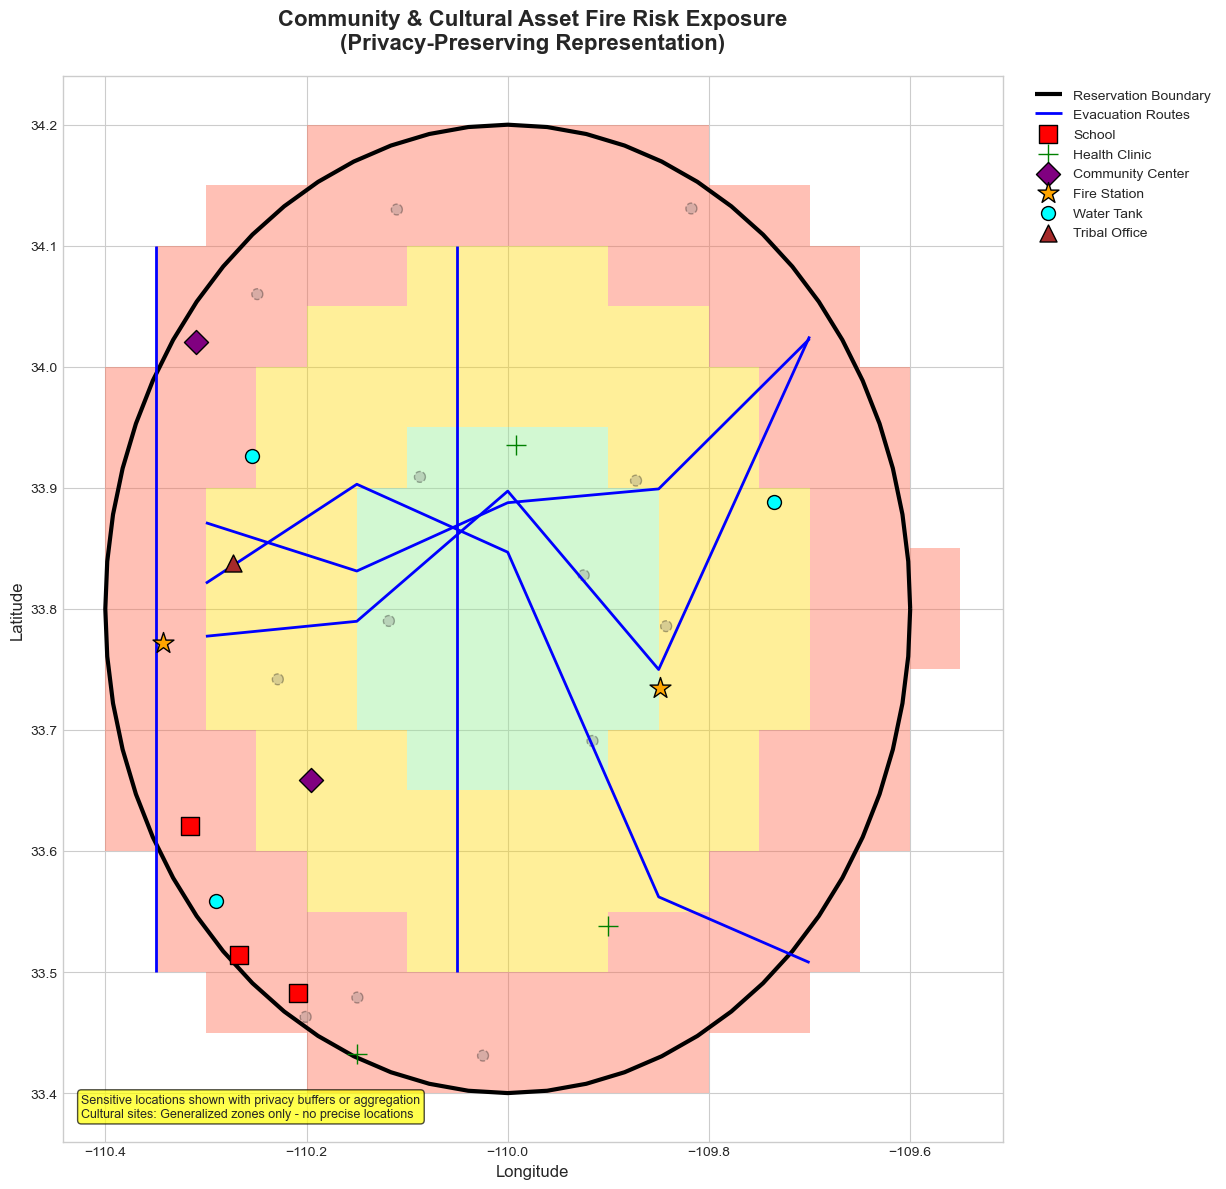


Asset exposure map saved to: asset_exposure_map.png


In [21]:
# Create exposure map
fig, ax = plt.subplots(figsize=(14, 12))

# Plot fire risk zones
risk_colors = {'Low': '#90EE90', 'Moderate': '#FFD700', 'High': '#FF6347'}
for risk_level, color in risk_colors.items():
    risk_data = fire_risk[fire_risk['risk_level'] == risk_level]
    risk_data.plot(
        ax=ax,
        color=color,
        alpha=0.4,
        edgecolor='none',
        label=f'{risk_level} Risk'
    )

# Plot reservation boundary
reservation_boundary.boundary.plot(
    ax=ax,
    color='black',
    linewidth=3,
    label='Reservation Boundary'
)

# Plot evacuation routes
evacuation_routes.plot(
    ax=ax,
    color='blue',
    linewidth=2,
    label='Evacuation Routes',
    zorder=3
)

# Plot community assets (PUBLIC only - exact locations)
public_assets = community_assets[community_assets['privacy_level'] == 'public']
asset_markers = {
    'School': ('s', 'red', 150),
    'Health Clinic': ('+', 'green', 200),
    'Community Center': ('D', 'purple', 150),
    'Fire Station': ('*', 'orange', 250),
    'Water Tank': ('o', 'cyan', 100),
    'Tribal Office': ('^', 'brown', 150)
}

for asset_type, (marker, color, size) in asset_markers.items():
    assets_type = public_assets[public_assets['type'] == asset_type]
    if len(assets_type) > 0:
        assets_type.plot(
            ax=ax,
            marker=marker,
            color=color,
            markersize=size,
            label=asset_type,
            zorder=4,
            edgecolor='black',
            linewidth=1
        )

# Plot sensitive assets (BUFFERED - no exact locations)
sensitive_assets = community_assets_buffered[
    community_assets_buffered['privacy_level'] == 'sensitive'
]
if len(sensitive_assets) > 0:
    sensitive_assets.plot(
        ax=ax,
        color='gray',
        alpha=0.3,
        edgecolor='black',
        linewidth=1,
        linestyle='--',
        label='Sensitive Areas (buffered)',
        zorder=2
    )

# Plot cultural sites (AGGREGATED ZONES ONLY)
if len(cultural_aggregated) > 0:
    cultural_aggregated.plot(
        ax=ax,
        color='none',
        edgecolor='magenta',
        linewidth=2,
        linestyle=':',
        hatch='///',
        alpha=0.3,
        label='Cultural Resource Zones (generalized)',
        zorder=1
    )

ax.set_title(
    'Community & Cultural Asset Fire Risk Exposure\n(Privacy-Preserving Representation)',
    fontsize=16,
    fontweight='bold',
    pad=20
)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Custom legend
ax.legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    framealpha=0.9,
    fontsize=10
)

# Add privacy notice
ax.text(
    0.02, 0.02,
    'Sensitive locations shown with privacy buffers or aggregation\n'
    'Cultural sites: Generalized zones only - no precise locations',
    transform=ax.transAxes,
    fontsize=9,
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7)
)

plt.tight_layout()
plt.savefig('C:\Miniconda\Tribal_fire_science\output', dpi=300, bbox_inches='tight')
plt.show()

print("\nAsset exposure map saved to: asset_exposure_map.png")

### Fire Scenario Maps

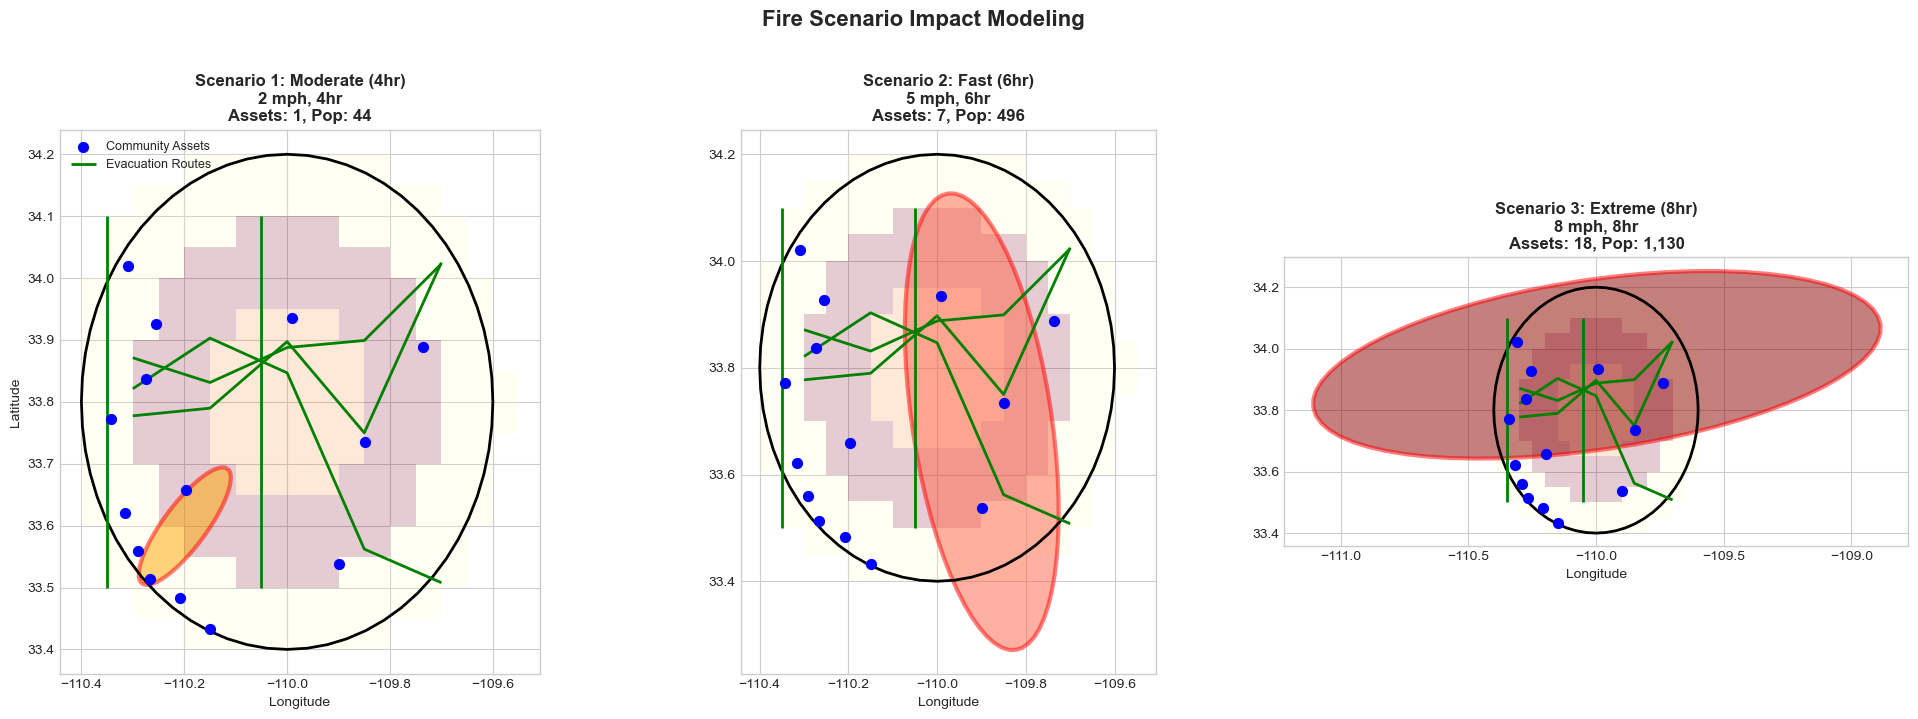


Fire scenario maps saved to: fire_scenarios.png


In [22]:
# Create scenario comparison map
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

scenario_colors = ['#FFA500', '#FF6347', '#8B0000']

for idx, (ax, (_, scenario)) in enumerate(zip(axes, all_scenarios.iterrows())):
    # Base layers
    reservation_boundary.boundary.plot(ax=ax, color='black', linewidth=2)
    
    fire_risk.plot(
        ax=ax,
        column='risk_level',
        categorical=True,
        legend=False,
        alpha=0.2,
        cmap='YlOrRd'
    )
    
    # Fire scenario perimeter
    scenario_gdf = gpd.GeoDataFrame([scenario], geometry='geometry', crs=all_scenarios.crs)
    scenario_gdf.plot(
        ax=ax,
        color=scenario_colors[idx],
        alpha=0.5,
        edgecolor='red',
        linewidth=3,
        label='Fire Perimeter'
    )
    
    # Community assets
    public_assets.plot(
        ax=ax,
        marker='o',
        color='blue',
        markersize=50,
        label='Community Assets',
        zorder=3
    )
    
    # Evacuation routes
    evacuation_routes.plot(
        ax=ax,
        color='green',
        linewidth=2,
        label='Evacuation Routes',
        zorder=2
    )
    
    # Calculate impacts
    impact = assess_scenario_impact(scenario_gdf, community_assets, evacuation_routes)
    
    # Title with stats
    title = f"{scenario['scenario_name']}\n"
    title += f"{scenario['spread_rate_mph']} mph, {scenario['duration_hours']}hr\n"
    title += f"Assets: {impact['assets_impacted']}, Pop: {impact['population_impacted']:,}"
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude' if idx == 0 else '')
    
    if idx == 0:
        ax.legend(loc='upper left', fontsize=9)

plt.suptitle(
    'Fire Scenario Impact Modeling',
    fontsize=16,
    fontweight='bold',
    y=1.02
)
plt.tight_layout()
plt.savefig('C:\Miniconda\Tribal_fire_science\output', dpi=300, bbox_inches='tight')
plt.show()

print("\nFire scenario maps saved to: fire_scenarios.png")

### Evacuation Route Risk Assessment

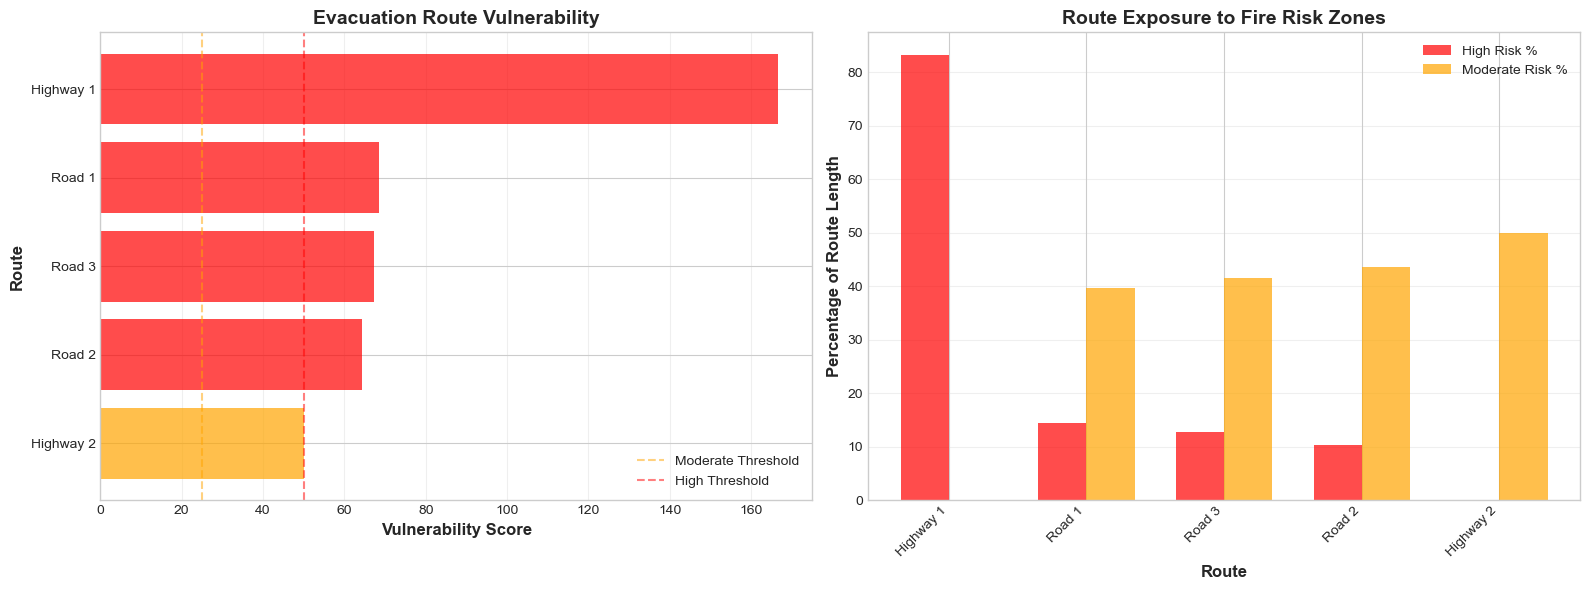


Evacuation route assessment saved to: evacuation_route_assessment.png


In [23]:
# Create evacuation route vulnerability chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Route vulnerability scores
route_assessment_sorted = route_assessment.sort_values('vulnerability_score', ascending=True)

colors = ['red' if x > 50 else 'orange' if x > 25 else 'green' 
          for x in route_assessment_sorted['vulnerability_score']]

ax1.barh(
    route_assessment_sorted['name'],
    route_assessment_sorted['vulnerability_score'],
    color=colors,
    alpha=0.7
)

ax1.axvline(x=25, color='orange', linestyle='--', alpha=0.5, label='Moderate Threshold')
ax1.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='High Threshold')

ax1.set_xlabel('Vulnerability Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Route', fontsize=12, fontweight='bold')
ax1.set_title('Evacuation Route Vulnerability', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3, axis='x')

# Chart 2: High-risk exposure
route_assessment_sorted_risk = route_assessment.sort_values('high_risk_pct', ascending=False)

x = np.arange(len(route_assessment_sorted_risk))
width = 0.35

ax2.bar(
    x - width/2,
    route_assessment_sorted_risk['high_risk_pct'],
    width,
    label='High Risk %',
    color='red',
    alpha=0.7
)

ax2.bar(
    x + width/2,
    route_assessment_sorted_risk['moderate_risk_pct'],
    width,
    label='Moderate Risk %',
    color='orange',
    alpha=0.7
)

ax2.set_xlabel('Route', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage of Route Length', fontsize=12, fontweight='bold')
ax2.set_title('Route Exposure to Fire Risk Zones', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(route_assessment_sorted_risk['name'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('C:\Miniconda\Tribal_fire_science\output', dpi=300, bbox_inches='tight')
plt.show()

print("\nEvacuation route assessment saved to: evacuation_route_assessment.png")

### Interactive Map (Privacy-Preserving)

## Export Results

In [ ]:
# Create output directory
import os
output_dir = 'C:\Miniconda\Tribal_fire_science\output'
os.makedirs(output_dir, exist_ok=True)

# Export PUBLIC data only
print("Exporting privacy-compliant outputs...")
print("="*80)

# 1. Community asset exposure (PUBLIC assets only)
public_exposure = community_exposure[
    community_exposure['privacy_level'] == 'public'
].copy()

public_exposure.to_csv(f'{output_dir}/public_asset_exposure.csv', index=False)
print(f"{output_dir}/public_asset_exposure.csv")

# 2. Aggregated summaries (no sensitive locations)
summary_stats = {
    'total_community_assets': len(community_assets),
    'public_assets': len(community_assets[community_assets['privacy_level'] == 'public']),
    'assets_high_risk': len(community_exposure[community_exposure['risk_level'] == 'High']),
    'population_high_risk': int(community_exposure[
        community_exposure['risk_level'] == 'High'
    ]['population'].sum()),
    'cultural_sites_analyzed': len(cultural_sites) if len(cultural_sites) > 0 else 'Not disclosed',
    'cultural_sites_high_risk': 'Aggregated only - count not disclosed'
}

with open(f'{output_dir}/summary_statistics.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"{output_dir}/summary_statistics.json")

# 3. Evacuation route assessment
route_assessment.to_csv(f'{output_dir}/evacuation_route_assessment.csv', index=False)
print(f"{output_dir}/evacuation_route_assessment.csv")

# 4. Scenario impacts (aggregated)
scenario_impacts = []
for idx, scenario in all_scenarios.iterrows():
    scenario_geom = gpd.GeoDataFrame([scenario], geometry='geometry', crs=all_scenarios.crs)
    impact = assess_scenario_impact(scenario_geom, community_assets, evacuation_routes)
    
    scenario_impacts.append({
        'scenario_name': scenario['scenario_name'],
        'spread_rate_mph': scenario['spread_rate_mph'],
        'duration_hours': scenario['duration_hours'],
        'assets_impacted': impact['assets_impacted'],
        'population_impacted': impact['population_impacted'],
        'routes_impacted': impact['routes_impacted']
    })

pd.DataFrame(scenario_impacts).to_csv(
    f'{output_dir}/scenario_impacts.csv',
    index=False
)
print(f"{output_dir}/scenario_impacts.csv")

print("\n" + "="*80)
print("SENSITIVE DATA NOT EXPORTED")
print("  - Cultural site locations: PROTECTED")
print("  - Residential locations: BUFFERED/AGGREGATED")
print("  - All outputs comply with Tribal data sovereignty")
print("="*80)

Exporting privacy-compliant outputs...
C:\Miniconda\Tribal_fire_science\output/public_asset_exposure.csv
C:\Miniconda\Tribal_fire_science\output/summary_statistics.json
C:\Miniconda\Tribal_fire_science\output/evacuation_route_assessment.csv
C:\Miniconda\Tribal_fire_science\output/scenario_impacts.csv

SENSITIVE DATA NOT EXPORTED
  - Cultural site locations: PROTECTED
  - Residential locations: BUFFERED/AGGREGATED
  - All outputs comply with tribal data sovereignty


### Generate Report

In [27]:
# Create comprehensive report
report = f"""
{'='*80}
COMMUNITY & CULTURAL ASSETS AT RISK FROM WILDFIRE
Privacy-Preserving Analysis
{'='*80}
Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Reservation: {sample_reservation['reservation_name']}

DATA SOVEREIGNTY & PRIVACY NOTICE
{'='*80}
This analysis respects Tribal data sovereignty and privacy:
  Cultural site locations are NOT disclosed
  Sensitive locations shown with privacy buffers only
  Aggregated zones used when feature count < {ANALYSIS_CONFIG['minimum_aggregation']}
  All outputs reviewed for privacy compliance
  Tribal consent obtained: {"Yes (example)" if CONSENT_OBTAINED else "Required"}

EXECUTIVE SUMMARY
{'='*80}

This analysis identifies community and cultural assets exposed to wildfire risk
while maintaining strict privacy protections and respecting Tribal data governance.

FINDINGS:

Community Infrastructure:
  - Total assets analyzed: {len(community_assets)}
  - Assets in high-risk zones: {len(community_exposure[community_exposure['risk_level'] == 'High'])}
  - Population in high-risk areas: {community_exposure[community_exposure['risk_level'] == 'High']['population'].sum():,}

Evacuation Routes:
  - Total routes: {len(evacuation_routes)}
  - Routes with high vulnerability: {len(route_assessment[route_assessment['vulnerability_score'] > 50])}
  - Total evacuation capacity: {evacuation_routes['capacity_vehicles_per_hour'].sum():,} vehicles/hour

Cultural Resources:
  - Analysis conducted: {"Yes" if len(cultural_sites) > 0 else "No (consent not obtained)"}
  - Results: Aggregated zones only - precise locations PROTECTED

DETAILED RESULTS
{'='*80}

COMMUNITY ASSET EXPOSURE
"""

# Add asset type breakdown
for asset_type in community_exposure['type'].unique():
    type_data = community_exposure[community_exposure['type'] == asset_type]
    high_risk = type_data[type_data['risk_level'] == 'High']
    
    report += f"\n{asset_type}:\n"
    report += f"  Total: {len(type_data)}\n"
    report += f"  High Risk: {len(high_risk)}\n"
    if 'population' in type_data.columns:
        report += f"  Population at high risk: {high_risk['population'].sum():,}\n"

report += f"""

EVACUATION ROUTE VULNERABILITY
{'='*80}
"""

for idx, route in route_assessment.iterrows():
    report += f"\n{route['name']}:\n"
    report += f"  Type: {route['type']}\n"
    report += f"  Length: {route['total_length_km']:.1f} km\n"
    report += f"  High-risk exposure: {route['high_risk_pct']:.1f}%\n"
    report += f"  Vulnerability score: {route['vulnerability_score']:.1f}\n"
    report += f"  Capacity: {route['capacity_vph']:,} vehicles/hour\n"

report += f"""

FIRE SCENARIO IMPACTS
{'='*80}
"""

for scenario_impact in scenario_impacts:
    report += f"\n{scenario_impact['scenario_name']}:\n"
    report += f"  Spread rate: {scenario_impact['spread_rate_mph']} mph\n"
    report += f"  Duration: {scenario_impact['duration_hours']} hours\n"
    report += f"  Assets impacted: {scenario_impact['assets_impacted']}\n"
    report += f"  Population impacted: {scenario_impact['population_impacted']:,}\n"
    report += f"  Routes threatened: {scenario_impact['routes_impacted']}\n"

report += f"""

RECOMMENDATIONS
{'='*80}

Based on this analysis, we recommend:

1. INFRASTRUCTURE PROTECTION
   - Prioritize defensible space around high-risk community facilities
   - Upgrade fire-resistant construction for critical infrastructure
   - Develop site-specific protection plans for schools and health clinics

2. EVACUATION PLANNING
   - Address high-vulnerability routes (score > 50)
   - Create alternative evacuation corridors
   - Pre-position resources along critical routes during high fire danger
   - Conduct evacuation drills and public education

3. CULTURAL RESOURCE PROTECTION
   - Work with Tribal cultural officers to develop protection strategies
   - Consider traditional fire management practices
   - Document traditional knowledge for fire planning
   - Maintain strict privacy for sensitive site locations

4. SCENARIO PREPAREDNESS
   - Develop response plans for fast-moving fire scenarios
   - Establish mutual aid agreements with neighboring jurisdictions
   - Enhance early warning systems
   - Create community fire shelters in gap areas

5. DATA GOVERNANCE
   - Maintain Tribal control over sensitive data
   - Update cultural site protections as needed
   - Regular review of privacy protocols
   - Continue collaboration with tribal GIS department

OUTPUT FILES
{'='*80}

All outputs saved to: {output_dir}/

Maps:
  - asset_exposure_map.png (privacy-preserving)
  - fire_scenarios.png
  - evacuation_route_assessment.png
  - interactive_asset_map.html (public assets only)

Data Tables (privacy-compliant):
  - public_asset_exposure.csv
  - evacuation_route_assessment.csv
  - scenario_impacts.csv
  - summary_statistics.json

WHAT IS NOT INCLUDED (PRIVACY PROTECTED):
  - Cultural site coordinates
  - Residential locations (exact)
  - Sensitive infrastructure (unbuffered)

{'='*80}
END OF REPORT
{'='*80}

FOR TRIBAL USE ONLY
This analysis and all outputs are the property of {sample_reservation['tribe']}.
External sharing or publication requires following Tribal data approval protocols.
"""

# Save report
report_path = f'{output_dir}/Asset_Risk_Analysis_Report.txt'
with open(report_path, 'w') as f:
    f.write(report)

print(f"\nReport saved to: {report_path}")
print("\n" + report)


Report saved to: C:\Miniconda\Tribal_fire_science\output/Asset_Risk_Analysis_Report.txt


COMMUNITY & CULTURAL ASSETS AT RISK FROM WILDFIRE
Privacy-Preserving Analysis
Report Generated: 2026-02-16 13:27
Reservation: White Mountain Apache

DATA SOVEREIGNTY & PRIVACY NOTICE
This analysis respects Tribal data sovereignty and privacy:
  Cultural site locations are NOT disclosed
  Sensitive locations shown with privacy buffers only
  Aggregated zones used when feature count < 3
  All outputs reviewed for privacy compliance
  Tribal consent obtained: Yes (example)

EXECUTIVE SUMMARY

This analysis identifies community and cultural assets exposed to wildfire risk
while maintaining strict privacy protections and respecting Tribal data governance.

FINDINGS:

Community Infrastructure:
  - Total assets analyzed: 27
  - Assets in high-risk zones: 15
  - Population in high-risk areas: 921

Evacuation Routes:
  - Total routes: 5
  - Routes with high vulnerability: 4
  - Total evacuation capacity: 

## Data Sources

### Data Sources:

**Community Infrastructure:**
- **Tribal GIS Departments**: PRIMARY source (with consent)
- **HIFLD** (Homeland Infrastructure Foundation-Level Data): Schools, hospitals
- **Census TIGER**: Building footprints
- **OpenStreetMap**: Some public facilities (verify accuracy)

**Cultural Sites:**
- **Tribal Cultural Preservation Offices**: authoritative source
- **State Historic Preservation Offices**: Some data (with restrictions)
- **BIA**: May have records (Tribal consent required)
- **NEVER use without explicit Tribal approval**

**Fire Risk:**
- **LANDFIRE**: Wildfire Hazard Potential (WHP)
- **State hazard assessments**
- **Tribal fire management plans**
- **Local fire departments**

**Roads/Evacuation:**
- **OpenStreetMap**: Road networks
- **State DOT**: Official road data
- **Tribal transportation departments**
- **Emergency management agencies**

### Privacy Best Practices:

1. **Always obtain explicit consent before using Tribal data**
2. **Store sensitive data in encrypted, access-controlled systems**
3. **Use minimum aggregation counts (≥3 features)**
4. **Apply appropriate spatial buffers to sensitive locations**
5. **Review all outputs with Tribal cultural, research, or data officers before sharing**
6. **Maintain chain of custody for sensitive data**
7. **Respect Tribal data governance protocols**
8. **Never export precise coordinates of cultural sites**

### TODO:

1. **Operational fire modeling**: FARSITE, FlamMap integration
2. **Real-time fire weather**: Link to RAWS stations
3. **Evacuation modeling**: HAZUS-MH integration
4. **Social vulnerability**: Integrate Census data
5. **Traditional knowledge**: Document traditional fire practices with consent
6. **Community engagement**: Participatory mapping exercises
7. **Mobile apps**: Field data collection for Tribal staff